In [1]:
import os
import glob
import random
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
from math import log,e,sqrt
from itertools import chain, compress
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Math

# Measuring peakiness

We want to look at the 'peakiness' of the distribution of PMI values for a given word.  Given a PMI matrix, where each row corresponds the the PMI of a given word with all the other words in the sentence, define peakiness as a function of a row of PMI values. $\text{peakiness}: \mathbb R^d \to \mathbb{R}[0,1]$


## Peakiness based on entropy
One intuitive measure is to make a length-dependent version of (inverse) entropy:
$$
\text{peakiness}(v) 
= 1 - \frac{S(v) }{ \log(d) }
$$
where 
$$
S(v) = -\sum_{i \in v} 
\frac i {\sum_{j \in v} j} \log(\frac i {\sum_{j \in v} j}),
$$
the entropy of the row, normalized, treated as a probability vector.

In [2]:
def entropy(vec, base=None):
    """ Computes entropy of unnormalized vector of floats. """
    total = sum(vec)
    probs = [i / total for i in vec]
    entropy = 0.
    base = e if base is None else base
    for p in probs:
        if p < 0:
            ent_p = np.inf
        elif p == 0:
            ent_p = 0.
        else:
            ent_p = p * log(p, base)
        entropy -= ent_p

    return entropy

In [3]:
# examples
def peakiness_entropy(vec, absolute=False):
    if len(vec) <= 1:
        return np.nan
    if absolute:
        vec = [abs(x) for x in vec]
    return 1 - entropy(vec) / log(len(vec))

# show examples
examples = ([1,0,0,0],[0,0,1,1],[0,0,10,10],[0,1,1,3],[1,1,1,1],
            [1,1,1,-1],[1],[0],[],
            [0,1,1],[0,1,1,0,0],[0,1,1,0,0,0,0,0,0])

# display(Math(r"\text{peakiness_entropy}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
# for pmi_vec in examples:
#     display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec)}"))

One issue, however, if we are going to treat a sequence of PMI scores as a probability vector, is that PMI may be negative.  An intuitive way to do this still eludes me.  Shifting the values by the minimum value will not preserve the intuitive peakiness (for instance, taking $[0,0,0,-2]$ to $[2,2,2,0]$ becomes much 'flatter' than it should).  Taking the absolute value is better, but also doesn't seem right, since the distinction between positive and negative is meaningful (in taking $[0,0,1,-1]$ to $[0,0,1,1]$, we lose the information that the penultimate position has the maximum PMI).

So, with absolute value:

In [4]:
# examples with abs
display(Math(r"\text{peakiness_entropy_abs}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec, absolute=True)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## Peakiness as "sparseness"

Another option, is 'sparseness' defined as a relationship between the $L_1$ and $L_2$ norms of a vector, $\text{sparseness}: \mathbb R^d \to \mathbb R[0,1]$.

$$
\text{sparseness}(v) = \frac
    {\left({\sqrt{d} - \dfrac{\|v\|_{L_1}}{\|v\|_{L_2}} }\right)}
    {\left({\sqrt{d}-1}\right)}
$$
from [Hoyer 2004](http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf) (§3.1)

In [5]:
def peakiness_sparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    l2 = sqrt(sum(x**2 for x in vec))
    numerator = sqrt(d) - l1 / l2
    return numerator / (sqrt(d) - 1)

# examples
display(Math(r"\text{peakiness_sparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_sparseness(pmi_vec)}"))
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# we could go farther, and get the difference between the L_1 and L_\infty norms.  
# This will give higher peakiness in general.

def peakiness_supersparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    linf = max(abs(x) for x in vec)
    numerator = d - l1 / linf
    return numerator / (d - 1)

# examples
display(Math(r"\text{peakiness_supersparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_supersparseness(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

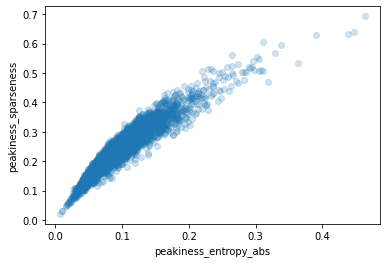

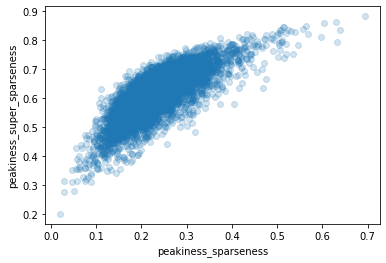

In [7]:
# comparing the measures

pairs = []
pairs2 = []
for i in range(500):
    # get a fake pmi matrix: 
    # a random square matrix size 5 to 30, populated with values in [-7,7]
    d = np.random.randint(25)+5
    pmis = 14 * np.random.sample((d,d)) - 7
    pmis = pmis + np.transpose(pmis) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=pmis)
    supersparseness = np.apply_along_axis(peakiness_supersparseness, axis=1, arr=pmis)
    entropy_abs = np.apply_along_axis(peakiness_entropy, axis=1, arr=pmis, absolute=True)
    pairs += list(zip(entropy_abs,sparseness))
    pairs2 += list(zip(sparseness,supersparseness))

plt.scatter(*zip(*pairs),alpha = 0.2)
plt.xlabel('peakiness_entropy_abs')
plt.ylabel('peakiness_sparseness')
plt.show()

plt.scatter(*zip(*pairs2),alpha = 0.2)
plt.xlabel('peakiness_sparseness')
plt.ylabel('peakiness_super_sparseness')
plt.show()

The for vectors in the middle of the range, the 'sparseness' measure is generally a bit higher than 'entropy_abs', and 'supersparseness' is even higher.  They're probably going to be similar, pracically.

In [8]:
# RESULTS_DIR = "results-clean/bert-base-cased_pad30_2020-08-07-03-41/" 
# RESULTS_DIR = "results-clean/bert-large-cased_pad60_2020-08-06-22-40/"
RESULTS_DIR = "results-clean/xlnet-base-cased_pad30_2020-08-07-09-12/"
matrices_npz = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))
logliks_npz = np.load(os.path.join(RESULTS_DIR, 'pseudo_logliks.npz'))

scores_path = glob.glob(RESULTS_DIR+'scores*.csv')[0]
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*.csv')[0]
wordpair = pd.read_csv(wordpair_path)
scores = pd.read_csv(scores_path)

In [48]:
# some short examples
count=0
for sentence, matrix in matrices_npz.items():
    sent = sentence.split(' ')
    if 4 < len(sent) < 8:
        print(f'sentence {sent[0]}\n\tsparseness\tentropy_abs')
        matrix = matrix + np.transpose(matrix) # symmetrize
        for i, row in enumerate(matrix):
            row = row[np.arange(len(row))!=i] # remove diagonal
            print(f'\t{peakiness_sparseness(row):.6f}\t{peakiness_entropy(row, absolute=True):.6f}\t{sent[i+1]}')
        print()
        count+=1
        if count > 2:
            break

sentence 66
	sparseness	entropy_abs
	0.319887	0.201014	Ad
	0.421113	0.202239	Notes
	0.405089	0.307326	...
	0.414412	0.198037	.

sentence 69
	sparseness	entropy_abs
	0.295968	0.131973	Terms
	0.444313	0.236984	were
	0.477222	0.220962	n't
	0.303386	0.132383	disclosed
	0.256554	0.112202	.

sentence 102
	sparseness	entropy_abs
	0.642064	0.404456	I
	0.792720	0.537052	love
	0.548168	0.402415	'em
	0.408073	0.235716	both
	0.675632	0.447691	.



In [9]:
lstm_pmi_matrices_npz = np.load('lstm_pmi_matrices.npz')
onlstm_pmi_matrices_npz = np.load('onlstm_pmi_matrices.npz')

In [35]:
i=1
print(lstm_pmi_matrices_npz.files[i])
print(matrices_npz.files[i])

23 <eos> budget director darman said he wo n't give federal agencies much leeway in coping with gramm-rudman spending cuts which took effect yesterday <eos>
1229 Budget director Darman said he wo n't give federal agencies much leeway in coping with Gramm-Rudman spending cuts , which took effect yesterday .


# Correlation of peakiness with dependency accuracy

## Mean peakiness vs undirected accuracy score

First, does mean peakiness over all words in a sentence correlate with sentence-wide accuracy UUAS = num correct / total edges ?

In [49]:
# Load the PTB data
from collections import namedtuple
class CONLLReader():
    def __init__(self, conll_cols, additional_field_name=None):
        if additional_field_name:
            conll_cols += [additional_field_name]
        self.conll_cols = conll_cols
        self.observation_class = namedtuple("Observation", conll_cols)
        self.additional_field_name = additional_field_name

    # Data input
    @staticmethod
    def generate_lines_for_sent(lines):
        '''Yields batches of lines describing a sentence in conllx.

        Args:
            lines: Each line of a conllx file.
        Yields:
            a list of lines describing a single sentence in conllx.
        '''
        buf = []
        for line in lines:
            if line.startswith('#'):
                continue
            if not line.strip():
                if buf:
                    yield buf
                    buf = []
                else:
                    continue
            else:
                buf.append(line.strip())
        if buf:
            yield buf

    def load_conll_dataset(self, filepath):
        '''Reads in a conllx file; generates Observation objects

        For each sentence in a conllx file, generates a single Observation
        object.

        Args:
            filepath: the filesystem path to the conll dataset
            observation_class: namedtuple for observations

        Returns:
        A list of Observations
        '''
        observations = []
        lines = (x for x in open(filepath))
        for buf in self.generate_lines_for_sent(lines):
            conllx_lines = []
            for line in buf:
                conllx_lines.append(line.strip().split('\t'))
            if self.additional_field_name:
                newfield = [None for x in range(len(conllx_lines))]
                observation = self.observation_class(
                    *zip(*conllx_lines), newfield)
            else:
                observation = self.observation_class(
                    *zip(*conllx_lines))
            observations.append(observation)
        return observations

CONLL_COLS = ['index',
              'sentence',
              'lemma_sentence',
              'upos_sentence',
              'xpos_sentence',
              'morph',
              'head_indices',
              'governance_relations',
              'secondary_relations',
              'extra_info']

OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(
    'ptb3-wsj-data/ptb3-wsj-dev.conllx')

In [50]:
# get peakiness scores for ptb data
av_sparseness = []
av_supersparseness = []
av_entropyabs = []
for i, obs in enumerate(tqdm(OBSERVATIONS)):
    sentence = str(' '.join([str(i), *obs.sentence]))
    matrix = matrices_npz[sentence]
    pseudo_loglik = logliks_npz[sentence]
    
    matrix = matrix + np.transpose(matrix) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=matrix)
    supersparseness = np.apply_along_axis(peakiness_supersparseness, axis=1, arr=matrix)
    entropyabs = np.apply_along_axis(peakiness_entropy, axis=1, arr=matrix, absolute=True)
    av_sparseness.append(np.mean(sparseness))
    av_supersparseness.append(np.mean(supersparseness))
    av_entropyabs.append(np.mean(entropyabs))

scores["av_sparseness"] = av_sparseness
scores["av_supersparseness"] = av_supersparseness
scores["av_entropyabs"] = av_entropyabs

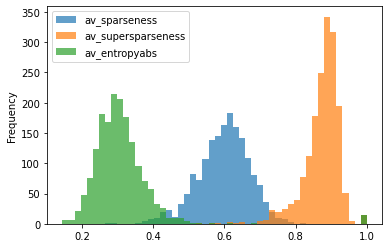

In [51]:
# Simple histograms of the per sentence averages of the three peakiness measures.
scores[['av_sparseness','av_supersparseness','av_entropyabs']].plot.hist(alpha=0.7,bins=50)
plt.show()

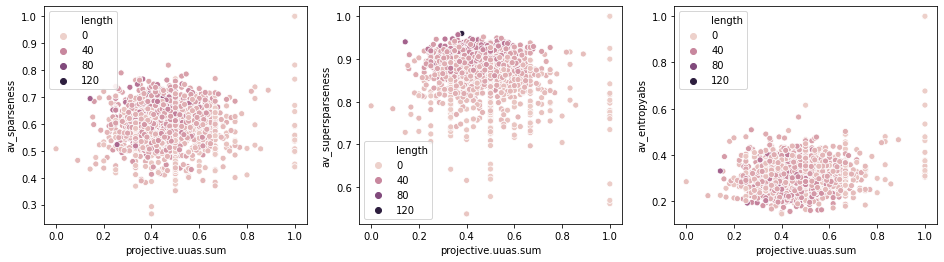

In [52]:
scores['length'] = scores['sentence_length'].astype(float)
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='projective.uuas.sum', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='projective.uuas.sum', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='projective.uuas.sum', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
plt.show()

Average peakiness per sentence doesn't look correlated with accuracy.

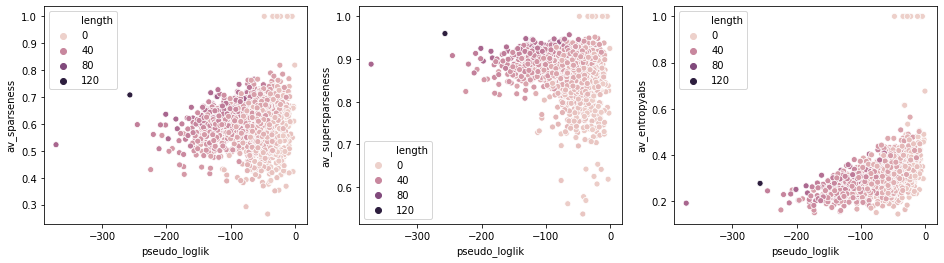

In [53]:
# just out of curiosity, does peakiness correlate with log likelihood? 
# this would be true if sentences which the model predicted very confidently
# it also predicted very markov-ly
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='pseudo_loglik', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='pseudo_loglik', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='pseudo_loglik', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
# fig.colorbar(fig)
plt.show()

## Per word peakiness

For a given word, does the peakiness of the row of CPMIs for that word with all other words in the sentence correlate with the correctness of its prediction?
That is, in a CPMI matrix, are the max values per row more likely to correspond to gold dependencies when the peakiness is high?

In [54]:
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*')[0]
wordpair = pd.read_csv(wordpair_path,dtype={'sentence_index': 'int'})

In [55]:
def insert_nan_diagonal(triu, tril):
    assert triu.shape==tril.shape
    d = triu.shape[0]
    upper = np.zeros((d+1,d+1))
    upper[:-1,1:] = triu
    lower = np.zeros((d+1,d+1))
    lower[1:,:-1] = tril
    matrix = np.nansum(np.dstack((upper, lower)),2)
    np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
    return matrix

def max_is_gold(pmi_row,gold_row):
    assert len(pmi_row)==len(gold_row)
    return bool(gold_row[np.argmax(pmi_row)])

def get_mask_from_df(df_idx, value_column='gold_edge'):
    '''get a boolean map (as nparray) for which edges
    correspond to edges from value_column eg, default 'gold_edge'
    '''
    df_val = df_idx.pivot_table(
        index='i1', columns='i2', values=value_column)
    map_val = df_val.to_numpy()
    map_val = insert_nan_diagonal(map_val, map_val.T)
    return map_val

In [56]:
# # An example.  dev sentence #31:
# idx=31
# print(f"Sentence {idx}:",
#       f"{int(scores.sentence_length[idx])} PTB tokens;",
#       f"{scores.number_edges[idx]-1} words; {scores.number_edges[idx]} edges")
# print(OBSERVATIONS[idx].sentence)
# df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index==idx)])
# print("Between PTB tokens, the following (absolute value) cpmis:")
# df_idx['pmi_sum_abs'] = abs(df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])
# print(df_idx.pivot_table(index='i1', columns='i2', values='pmi_sum_abs'))

# triu = df_idx.pivot_table(index='i1', columns='i2', values='pmi_triu').to_numpy()
# tril = df_idx.pivot_table(index='i1', columns='i2', values='pmi_tril').to_numpy().T
# matrix = insert_nan_diagonal(triu, tril)
# matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))),2)) # symmetrize and absolute value
# np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
# print(f"symmetrized absolute valued matrix:\n{matrix}")

# # The is_gold matrix shows which edges correspond to gold edges
# df_idx_is_gold = df_idx.pivot_table(index='i1', columns='i2', values='gold_edge')
# print(df_idx_is_gold)
# matrix_is_gold = df_idx_is_gold.to_numpy()
# matrix_is_gold = insert_nan_diagonal(matrix_is_gold,matrix_is_gold.T)
# print(f"symmetrized is gold:\n{matrix_is_gold}\n")

# indices = set(df_idx.i1.unique()).union(df_idx.i2.unique())
# sentence_words = [OBSERVATIONS[idx].sentence[i] for i in indices]

# print(f'{idx}\tword\tsparseness\tentropy_abs\tmax==gold')
# for i, row in enumerate(np.hstack((matrix,matrix_is_gold))):
#     pmi_row, gold_row = np.split(row,2)
#     pmi_row = pmi_row[np.arange(len(pmi_row))!=i] # remove diagonal entries
#     gold_row = gold_row[np.arange(len(gold_row))!=i]
#     print(f'\t{sentence_words[i]}',
#           f'\t{peakiness_sparseness(pmi_row):.6f}',
#           f'\t{peakiness_entropy(pmi_row, absolute=True):.6f}',
#           f'\t{max_is_gold(pmi_row,gold_row)}',
#           sep='')

In [57]:
def get_per_word_peakiness_scores(observations, wordpair):
    data_list = []
    for idx, observation in tqdm(enumerate(observations)):
        df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index == idx)])
        df_idx['pmi_sum_abs'] = abs(
            df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])

        triu = df_idx.pivot_table(
            index='i1', columns='i2', values='pmi_triu').to_numpy()
        tril = df_idx.pivot_table(
            index='i1', columns='i2', values='pmi_tril').to_numpy().T
        matrix = insert_nan_diagonal(triu, tril)
        # symmetrize and absolute value
        matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))), 2))
        np.fill_diagonal(matrix, np.NaN)  # should ignore diagonal

        # The is_gold matrix shows which edges correspond to gold edges
        matrix_is_gold = get_mask_from_df(df_idx, value_column='gold_edge')
        # The is_pmiedge matrices shows which edges correspond to pmi edges
        matrix_is_pmiedge_proj = get_mask_from_df(
            df_idx, value_column='pmi_edge_sum')
        matrix_is_pmiedge_nonproj = get_mask_from_df(
            df_idx, value_column='pmi_edge_nonproj_sum')

        indices = set(df_idx.i1.unique()).union(df_idx.i2.unique())
        sentence_words = [OBSERVATIONS[idx].sentence[i] for i in indices]

        if len(sentence_words) > 0:  # ignore sentences with no edges
            for i, row in enumerate(np.hstack((
                    matrix, matrix_is_gold,
                    matrix_is_pmiedge_proj,matrix_is_pmiedge_nonproj))):
                data = {}
                (pmi_row, gold_row,
                    edge_proj_row, edge_nonproj_row) = np.split(row, 4)
                # remove meaningless diagonal entries from the rows
                pmi_row = pmi_row[np.arange(len(pmi_row)) != i]
                gold_row = gold_row[np.arange(len(gold_row)) != i]
                edge_proj_row = edge_proj_row[np.arange(len(edge_proj_row)) != i]
                edge_nonproj_row = edge_nonproj_row[np.arange(len(edge_nonproj_row)) != i]
                data['sentence_index'] = idx
                data['word'] = sentence_words[i]
                data['peakiness_sparseness'] = peakiness_sparseness(pmi_row)
                data['peakiness_supersparseness'] = peakiness_supersparseness(
                    pmi_row)
                data['peakiness_entropyabs'] = peakiness_entropy(
                    pmi_row, absolute=True)
                data['max_is_gold'] = max_is_gold(pmi_row, gold_row)
                data['pmi_row'] = pmi_row
                data['gold_row'] = gold_row
                data['edge_proj_row'] = edge_proj_row
                data['edge_nonproj_row'] = edge_nonproj_row
                data_list.append(data)
    return data_list

peakiness_scores = pd.DataFrame(
    get_per_word_peakiness_scores(OBSERVATIONS, wordpair))

In [58]:
for df in [peakiness_scores]:    
    df["gold_peakiness_sparseness"] = df.apply(
        lambda x: peakiness_sparseness(x['gold_row']), axis=1)
    df["gold_peakiness_supersparseness"] = df.apply(
        lambda x: peakiness_supersparseness(x['gold_row']), axis=1)
    df["gold_peakiness_entropyabs"] = df.apply(
        lambda x: peakiness_entropy(x['gold_row'], absolute=True), axis=1)

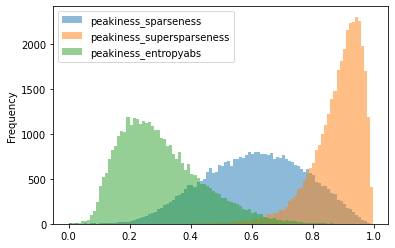

In [59]:
# Histograms of the per word averages of the three peakiness measures.
peakiness_scores[[
    'peakiness_sparseness',
    'peakiness_supersparseness',
    'peakiness_entropyabs']].plot.hist(alpha=0.5,bins=100)
plt.show()

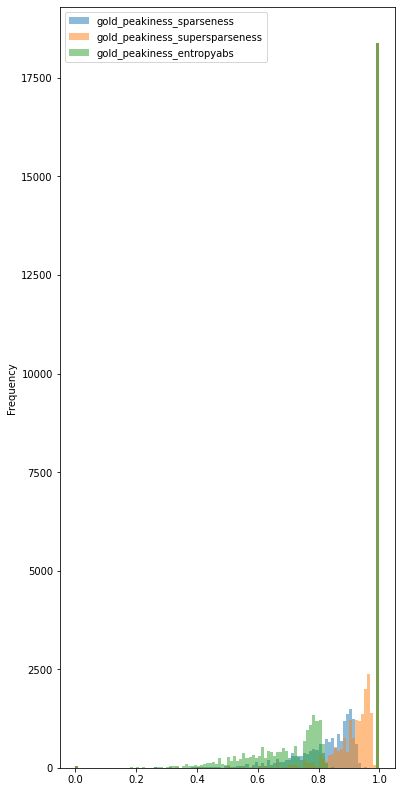

In [60]:
f = peakiness_scores[[
    'gold_peakiness_sparseness',
    'gold_peakiness_supersparseness',
    'gold_peakiness_entropyabs']].plot.hist(alpha=0.5,bins=100,figsize=(6,14))
plt.show()

mean: 0.7573698309472591, std:1.717210542862855


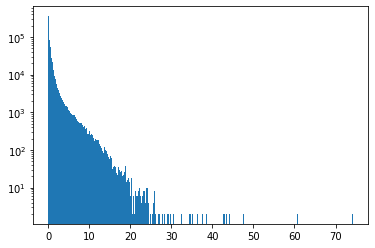

In [61]:
all_cpmi_values = pd.Series(chain(*peakiness_scores.pmi_row.values))
print(f'mean: {all_cpmi_values.mean()}, std:{all_cpmi_values.std()}')
plt.hist(all_cpmi_values, bins=500)
plt.yscale('log')
# plt.xscale('log')
plt.show()

Well, the CPMI values are rather sparse (most values are basically 0).

In [62]:
# The sentence indices which were skipped 
# check that it's just those with less than two (nonpunctuation) words.
skipped_sentence_indices = sorted(set(range(1700)).difference(set(peakiness_scores.sentence_index.values)))
print(skipped_sentence_indices)

obs_df=pd.DataFrame(OBSERVATIONS)
for index in skipped_sentence_indices:
    obs = obs_df.loc[index]
    print(index, obs.sentence, sep='\t')

[67, 74, 210, 267, 288, 294, 318, 382, 385, 653, 775, 975, 989, 992, 998, 1008, 1243, 1364, 1373, 1388, 1397, 1406]
67	('ARNOLD', 'ADVERTISING', ':')
74	('EDUCATION', 'ADS', ':')
210	('Frank', 'Tremdine')
267	('FRANKFURT', ':')
288	('LONDON', ':')
294	('PARIS', ':')
318	('NCNB', 'Corp', '.')
382	('Idle', 'Thought')
385	('Telecussed',)
653	('Absolutely', 'not', '.')
775	('Then', 'exhilaration', '.')
975	('Treasury', 'Securities')
989	('Corporate', 'Issues')
992	('Foreign', 'Bonds')
998	('Mortgage-Backed', 'Securities')
1008	('Municipals',)
1243	('Markets', '--')
1364	('ENERGY', ':')
1373	('COPPER', ':')
1388	('COTTON', ':')
1397	('SUGAR', ':')
1406	('FARM', 'PRODUCTS', ':')


### Correlation between peakiness and accuracy

Partition the words in the dataset into two sets, the ones which predict a gold dependency, and the ones which don't.  

That is, letting $\mathrm{row}_w$ denote the row of CPMI scores corresponding to word $w$, 

1. $T = \{ w \in D\mid  i=\arg\max(\mathrm{row_w})$ is the index of a word with which w is in a gold dependency relationship$\}$.
2. $F = \{ w \in D\mid i=\arg\max(\mathrm{row_w})$ is *not* the index of a word with which w is in a gold dependency relationship$\}$.

So we should test correlation
- Alternative hypothesis: the distributions of peakiness over T and F are different (specifically, that T has higher mean than F).

- Null hypothesis: the distributions of peakiness over T and F are the same.

In [63]:
def plot_peakiness_accuracy(df, sparseness_measure, figsize=(7, 5)):
    f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, 
                                                 gridspec_kw={"height_ratios": (.15,.15,.7)},
                                                 figsize=figsize) 
    vals = [True, False]
    colors = sns.color_palette("deep")
    ax_box = [ax_box1,ax_box2]

    for i in [0,1]:
        sns.boxenplot(df[df["max_is_gold"]==vals[i]][sparseness_measure], color=colors[i],
                      k_depth="tukey", scale='exponential',
                      ax=ax_box[i])
        sns.distplot(
            df[df["max_is_gold"] == vals[i]][sparseness_measure], ax=ax_hist, bins=75, kde=True)

    # # Remove x axis name for the boxplot
    ax_box1.set(xlabel='argmax of row is gold = TRUE')
    ax_box2.set(xlabel='argmax of row is gold = FALSE')
    plt.show()

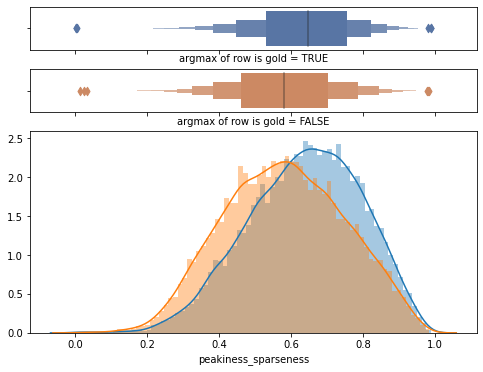

In [64]:
plot_peakiness_accuracy(peakiness_scores, "peakiness_sparseness", figsize=(8, 6))

It looks like the effect isn't very big, but it might very well be significant.  Here are the other two measures, just for comparison. They seem to show the same.

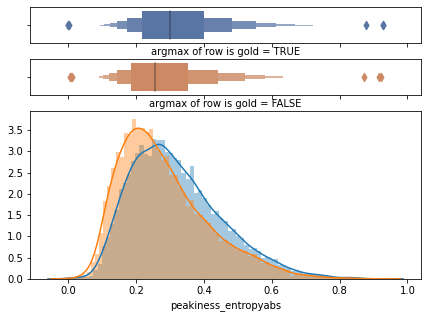

In [65]:
# plot_peakiness_accuracy(peakiness_scores, "peakiness_supersparseness")
plot_peakiness_accuracy(peakiness_scores, "peakiness_entropyabs")

### Statistical significance:

In [66]:
def ttest_ind_report(data1, data2, equal_var=False, alpha=0.05):
    CI = int(100 * (1-alpha))
    ttest = scipy.stats.ttest_ind(data1, data2, equal_var=equal_var)
    N1,N2 = len(data1),len(data2)
    df = (N1 + N2 - 2)
    std1,std2 = data1.std(),data2.std()
    std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 
    diff_mean = data1.mean() - data2.mean()
    margin_of_error = scipy.stats.t.ppf(1-alpha/2, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
    with_ev = 'with' if equal_var else 'without'
    print(f'Independent t-test, {with_ev} equal variance assumption:')
    print(f'\tt-value = {ttest.statistic:4.3f}\n\tp-value = {ttest.pvalue:4.3f}')
    print(f'difference between groups is {diff_mean:3.3f} [+- {margin_of_error:3.3f}],'
          f'(mean [{CI}% CI])')

def mwu_report(x,y):
    mwu = scipy.stats.mannwhitneyu(x, y, alternative="less")
    N_x, N_y = len(x), len(y)
    print("Mann-Whitney U test / Wilcoxon rank-sum test:")
    print(f"\tN_x: {N_x}\t\tN_y:{N_y}")
    print(f"\tmedian x: {x.median():.4f}\tmedian y:{y.median():.4f}")
    print(f"\tU = {mwu.statistic}")
    print(f"\tp = {mwu.pvalue:.4f}")
    mu = 0.5*N_x*N_y
    sigma = sqrt((mu/2 * (N_x+N_y))/12)
    # probability will that a score sampled at random 
    # from one distribution will be greater than a 
    # score sampled from some other distribution.
    print(f"common language effect size: \
    {mwu.statistic/(2*mu):.4f}")

    z= 1.64  # 1.64 for one tailed, sig level 0.05
    # z= 2.33  # 2.33 for one tailed, sig level 0.01
    u_crit = mu - z*sigma - 0.5
    print(f"U_crit = {u_crit}")
    print(f"U < U_crit = significant = {mwu.statistic < u_crit}")
    
true_sparseness = peakiness_scores[peakiness_scores.max_is_gold==True].peakiness_sparseness
false_sparseness = peakiness_scores[peakiness_scores.max_is_gold==False].peakiness_sparseness

mwu_report(false_sparseness,true_sparseness)
print()
ttest_ind_report(false_sparseness,true_sparseness,equal_var=False)

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 16891		N_y:18518
	median x: 0.5795	median y:0.6467
	U = 124953208.0
	p = 0.0000
common language effect size:     0.3995
U_crit = 155605988.8078389
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -32.903
	p-value = 0.000
difference between groups is -0.057 [+- 0.003],(mean [95% CI])


The difference small, but is **very significant** (p<0.001 for both the Wilcoxon rank-sum, and t-test). Likewise for the other measures:

In [67]:
# true_entropyabs = df[df.max_is_gold==True].peakiness_entropyabs
# false_entropyabs = df[df.max_is_gold==False].peakiness_entropyabs
# true_supersparseness = df[df.max_is_gold==True].peakiness_supersparseness
# false_supersparseness = df[df.max_is_gold==False].peakiness_supersparseness
# print("peakiness measured as entropyabs:")
# ttest_ind_report(true_entropyabs,false_entropyabs,equal_var=False)
# print("\npeakiness measured as supersparseness:")
# ttest_ind_report(true_supersparseness,false_supersparseness,equal_var=False)

In [68]:
# print("peakiness measured as entropyabs:")
# mwu_report(false_entropyabs, true_entropyabs)
# print("\npeakiness measured as supersparseness:")
# mwu_report(false_supersparseness,true_supersparseness)

### How often is argmax is right?
- `bert-base-cased` : about 57% of the time
- `bert-large-cased`: about 59% of the time

In [69]:
# (note, there are multiple potential edges from a single word, so this is not a good score)
len(peakiness_scores[peakiness_scores["max_is_gold"]==True])/len(peakiness_scores)

0.5229743850433506

In [70]:
peakiness_scores.columns

Index(['sentence_index', 'word', 'peakiness_sparseness',
       'peakiness_supersparseness', 'peakiness_entropyabs', 'max_is_gold',
       'pmi_row', 'gold_row', 'edge_proj_row', 'edge_nonproj_row',
       'gold_peakiness_sparseness', 'gold_peakiness_supersparseness',
       'gold_peakiness_entropyabs'],
      dtype='object')

## Show that max pmi and sparseness have to be related

To test the robustness, we will permute all of the edges that are _not_ used by the decoding algorithm (Prim's for nonprojective, or Eisner's for projectives).  That is, for the structures defined by one algorithm, fix CPMI values for wordpairs that are connected by an edge, and shuffle (globally) all CPMI values for wordpairs not connected by an edge.

In [71]:
def replace_from_unused(r, global_list=None, edge_mask=None):
    '''Put shuffled values in unused parts of PMI row. 

    Inputs:
        r: observed row of wordpair_scores df
        global_list: flat list of shuffled PMI scores. will be popped.
        edge_mask: column name for type of edge to preserve (proj or nonproj)
    match list to mask type e.g.: 
        global_list = pmi_unused_proj
        edge_mask = "edge_proj_row"
    '''
    pmi_row = r['pmi_row']
    mask = r[edge_mask]
    return [pmi if mask[i] else global_list.pop() for i, pmi in enumerate(pmi_row)]


# get the pmi scores for edges that are not used
pmi_unused_proj = list(chain(*list(peakiness_scores.apply(
    lambda x: list(compress(x['pmi_row'], (1 - x['edge_proj_row']))),
    axis=1).values)))
pmi_unused_nonproj = list(chain(*list(peakiness_scores.apply(
    lambda x: list(compress(x['pmi_row'], (1 - x['edge_nonproj_row']))),
    axis=1).values)))
pmi_unused_proj_rand = random.sample(pmi_unused_proj, len(pmi_unused_proj))
pmi_unused_nonproj_rand = random.sample(
    pmi_unused_nonproj, len(pmi_unused_nonproj))

peakiness_scores_randproj = peakiness_scores[[
    'sentence_index', 'word', 'gold_row', 'edge_proj_row', 'edge_nonproj_row']].copy()
peakiness_scores_randproj['pmi_row'] = peakiness_scores.apply(
    replace_from_unused,
    axis=1, global_list=pmi_unused_proj_rand, edge_mask='edge_proj_row')

peakiness_scores_randnonproj = peakiness_scores[[
    'sentence_index', 'word', 'gold_row', 'edge_proj_row', 'edge_nonproj_row']].copy()
peakiness_scores_randnonproj['pmi_row'] = peakiness_scores.apply(
    replace_from_unused,
    axis=1, global_list=pmi_unused_nonproj_rand, edge_mask='edge_nonproj_row')

In [72]:
for df in [peakiness_scores_randproj, peakiness_scores_randnonproj]:
    df['peakiness_sparseness'] = df.apply(
        lambda x: peakiness_sparseness(x['pmi_row']), axis=1)
    df['peakiness_supersparseness'] = df.apply(
        lambda x: peakiness_supersparseness(x['pmi_row']), axis=1)
    df['peakiness_entropyabs'] = df.apply(
        lambda x: peakiness_entropy(x['pmi_row'], absolute=True), axis=1)
    df['max_is_gold'] = df.apply(
        lambda x: max_is_gold(x['pmi_row'], x['gold_row']), axis=1)
    df["gold_peakiness_sparseness"] = df.apply(
        lambda x: peakiness_sparseness(x['gold_row']), axis=1)
    df["gold_peakiness_supersparseness"] = df.apply(
        lambda x: peakiness_supersparseness(x['gold_row']), axis=1)
    df["gold_peakiness_entropyabs"] = df.apply(
        lambda x: peakiness_entropy(x['gold_row'], absolute=True), axis=1)

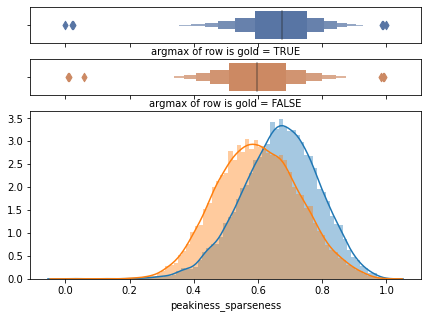

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 19016		N_y:16393
	median x: 0.5971	median y:0.6737
	U = 106868796.0
	p = 0.0000
common language effect size:     0.3428
U_crit = 155078197.57930934
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -52.186
	p-value = 0.000
difference between groups is -0.069 [+- 0.003],(mean [95% CI])


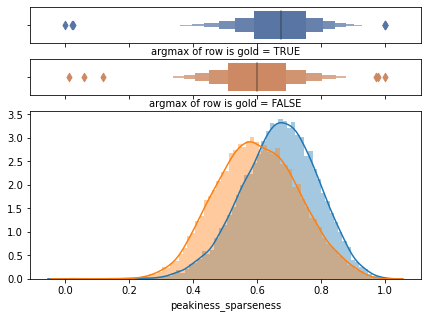

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 18939		N_y:16470
	median x: 0.5986	median y:0.6736
	U = 108262193.0
	p = 0.0000
common language effect size:     0.3471
U_crit = 155175971.32599548
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -51.000
	p-value = 0.000
difference between groups is -0.067 [+- 0.003],(mean [95% CI])


In [73]:
plot_peakiness_accuracy(peakiness_scores_randproj, "peakiness_sparseness")
true_sparseness_randproj = peakiness_scores_randproj[peakiness_scores_randproj.max_is_gold==True].peakiness_sparseness
false_sparseness_randproj = peakiness_scores_randproj[peakiness_scores_randproj.max_is_gold==False].peakiness_sparseness
mwu_report(false_sparseness_randproj,true_sparseness_randproj)
print()
ttest_ind_report(false_sparseness_randproj,true_sparseness_randproj,equal_var=False)

plot_peakiness_accuracy(peakiness_scores_randnonproj, "peakiness_sparseness")
true_sparseness_randnonproj = peakiness_scores_randnonproj[peakiness_scores_randnonproj.max_is_gold==True].peakiness_sparseness
false_sparseness_randnonproj = peakiness_scores_randnonproj[peakiness_scores_randnonproj.max_is_gold==False].peakiness_sparseness
mwu_report(false_sparseness_randnonproj,true_sparseness_randnonproj)
print()
ttest_ind_report(false_sparseness_randnonproj,true_sparseness_randnonproj,equal_var=False)



## Absolute value of PMI

In [74]:
def add_pmi_info_columns(df):
    df["pmi_row_max"] = df.apply(lambda x: np.max(x['pmi_row']),axis=1)
    df["pmi_row_logmax"] = df.apply(lambda x: log(np.max(x['pmi_row'])),axis=1)
    df["pmi_row_min"] = df.apply(lambda x: np.min(x['pmi_row']),axis=1)

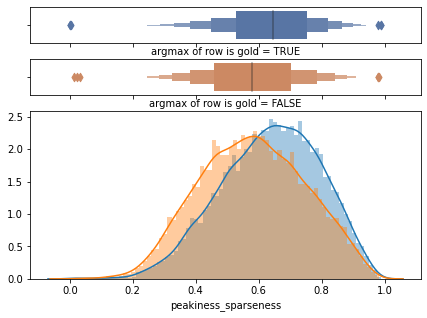

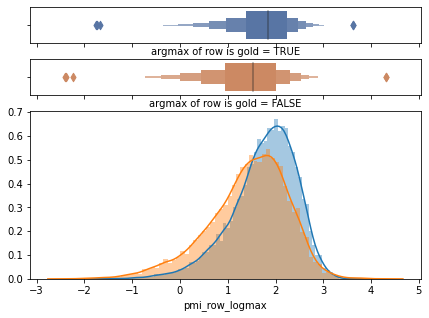

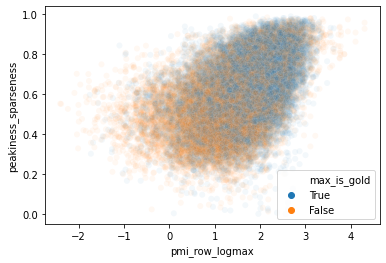

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 16891		N_y:18518
	median x: 4.6027	median y:6.3750
	U = 118249261.0
	p = 0.0000
common language effect size:     0.3780
U_crit = 155605988.8078389
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -31.929
	p-value = 0.000
difference between groups is -1.459 [+- 0.089],(mean [95% CI])


In [75]:
add_pmi_info_columns(peakiness_scores)

plot_peakiness_accuracy(peakiness_scores, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores, "pmi_row_logmax")

sns.scatterplot(data = peakiness_scores,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()

true_pmimax = peakiness_scores[peakiness_scores.max_is_gold==True].pmi_row_max
false_pmimax = peakiness_scores[peakiness_scores.max_is_gold==False].pmi_row_max

mwu_report(false_pmimax,true_pmimax)
print()
ttest_ind_report(false_pmimax,true_pmimax,equal_var=False)

# true_pmimean = peakiness_scores[peakiness_scores.max_is_gold==True].pmi_row_mean
# false_pmimean = peakiness_scores[peakiness_scores.max_is_gold==False].pmi_row_mean

# mwu_report(false_pmimean,true_pmimean)
# print()
# ttest_ind_report(true_pmimean,false_pmimean,equal_var=False)
# print(len(peakiness_scores))

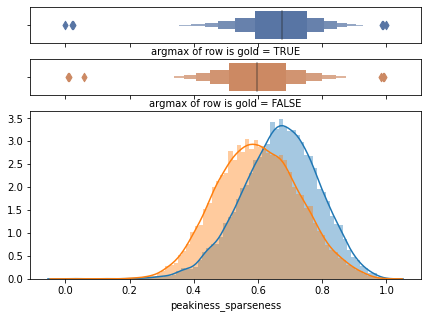

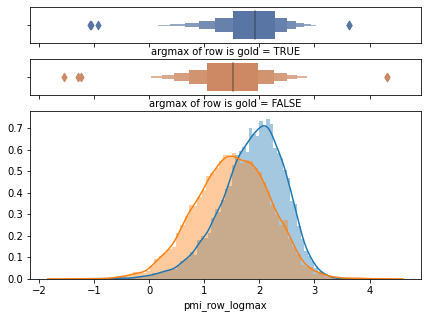

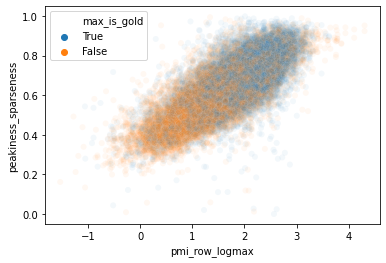

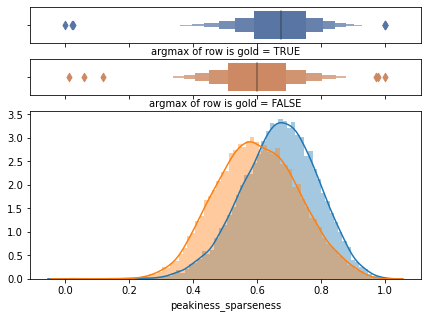

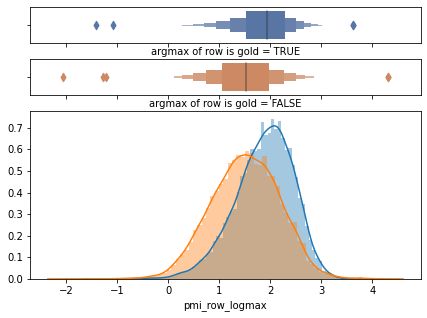

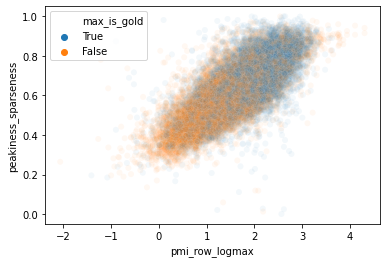

In [76]:
# Abs val max pmi in shuffled data.

add_pmi_info_columns(peakiness_scores_randproj)
plot_peakiness_accuracy(peakiness_scores_randproj, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores_randproj, "pmi_row_logmax")
sns.scatterplot(data = peakiness_scores_randproj,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()


add_pmi_info_columns(peakiness_scores_randnonproj)
plot_peakiness_accuracy(peakiness_scores_randnonproj, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores_randnonproj, "pmi_row_logmax")
sns.scatterplot(data = peakiness_scores_randnonproj,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()



## PMI magnitude effect interaction with arclength

In [77]:
wordpair['pmi_sum_abs'] = wordpair.apply(lambda x: abs(x['pmi_sum']), axis=1)

In [78]:
len(wordpair[wordpair.gold_edge==True].pmi_sum_abs)/len(wordpair.pmi_sum_abs)

0.07718623000036613

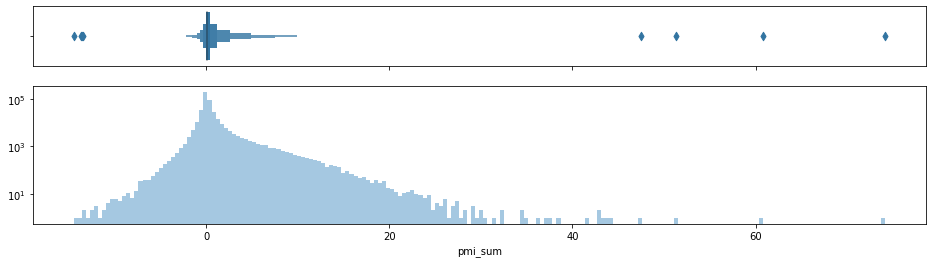

In [79]:
def plot_pmi_hist(df, score, figsize=(7, 5)):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.3,.7)},
                                        figsize=figsize) 

    sns.boxenplot(df[score], ax=ax_box, k_depth="tukey", scale='exponential')
    sns.distplot(df[score], ax=ax_hist, bins=200, kde=False)

    # # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.yscale('log')
    plt.show()
    
plot_pmi_hist(wordpair, score='pmi_sum', figsize=(16, 4))

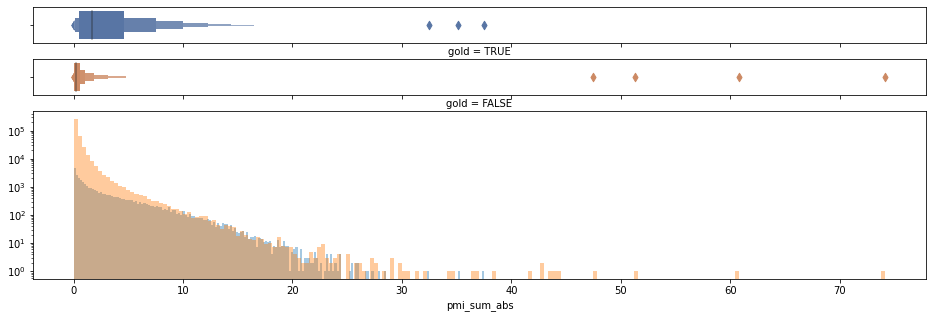

In [80]:
def plot_pmi_accuracy(df, score, figsize=(7, 5)):
    f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, 
                                                 gridspec_kw={"height_ratios": (.15,.15,.7)},
                                                 figsize=figsize) 
    vals = [True, False]
    colors = sns.color_palette("deep")
    ax_box = [ax_box1,ax_box2]

    for i in [0,1]:
        sns.boxenplot(df[df["gold_edge"]==vals[i]][score], color=colors[i], ax=ax_box[i],
                      k_depth="tukey", scale='exponential')
        sns.distplot(
            df[df["gold_edge"] == vals[i]][score], ax=ax_hist, bins=200, kde=False)

    # # Remove x axis name for the boxplot
    ax_box1.set(xlabel='gold = TRUE')
    ax_box2.set(xlabel='gold = FALSE')
    plt.yscale('log')
    plt.show()
    
plot_pmi_accuracy(wordpair, score='pmi_sum_abs', figsize=(16, 5))

lin_dist == 1:


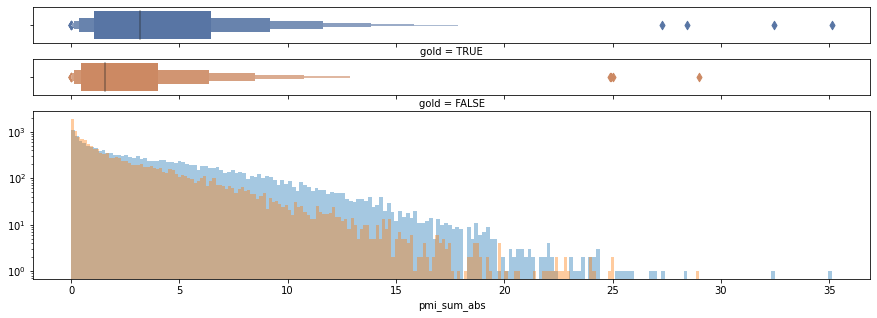

lin_dist > 1:


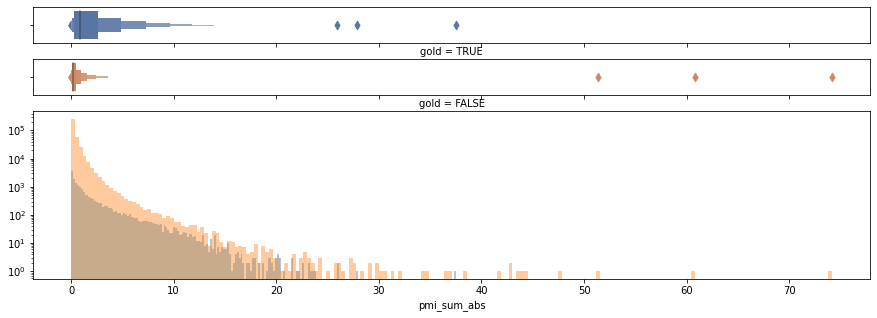

In [81]:
print("lin_dist == 1:")
plot_pmi_accuracy(wordpair[wordpair.lin_dist==1], score='pmi_sum_abs', figsize=(15, 5))
print("lin_dist > 1:")
plot_pmi_accuracy(wordpair[wordpair.lin_dist>1], score='pmi_sum_abs', figsize=(15, 5))

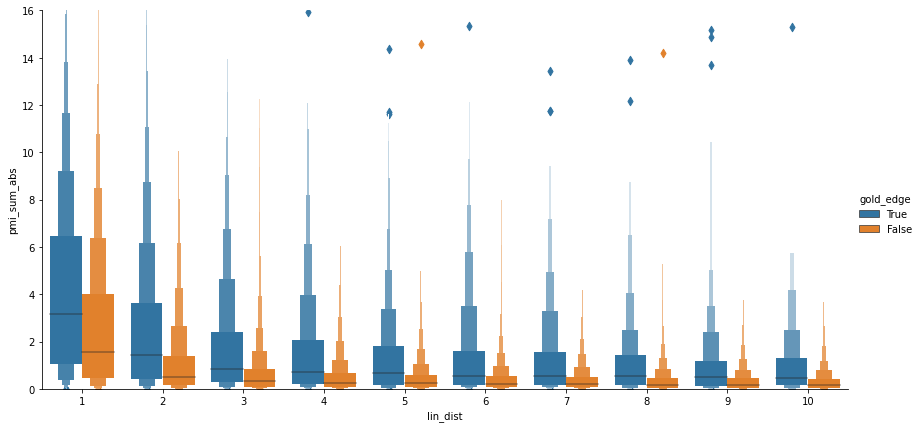

In [82]:
# wordpair[wordpair.lin_dist<=10][['gold_edge','lin_dist','pmi_sum_abs']].boxplot(
#     by='lin_dist',column=['pmi_sum_abs'], figsize=(16,5))
# plt.ylim(0,8)
# plt.show()
sns.catplot(
    kind='boxen', height=6, aspect=2, k_depth="tukey", scale='exponential',
    data=wordpair[wordpair.lin_dist<=10],
    x='lin_dist',y='pmi_sum_abs',hue='gold_edge', hue_order=[True,False])
plt.ylim(0,16)
plt.show()

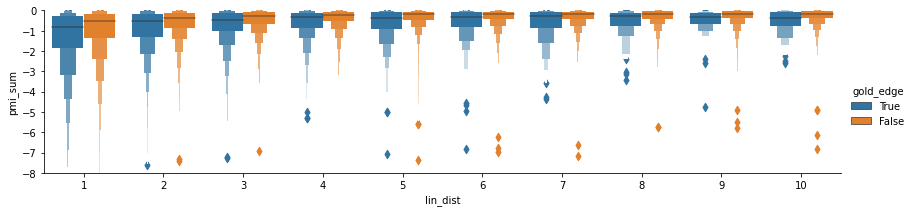

In [83]:
# also, just looking at negative CPMI values, the effect is in the opposite direction, 
# so using the absolute value is justified (or at least, it amplifies the effect)
sns.catplot(
    kind='boxen', height=3, aspect=4, k_depth="tukey", scale='exponential',
    data=wordpair[(wordpair.lin_dist<=10) & (wordpair.pmi_sum < 0)],
    x='lin_dist',y='pmi_sum',hue='gold_edge', hue_order=[True,False])
plt.ylim(-8,0)
plt.show()

The effect is much smaller for shorter arclengths.

In [46]:
# stats to read, if you like that:
lin_dist_df = wordpair.groupby(['lin_dist','gold_edge'])['pmi_sum_abs'].describe()
lin_dist_df.head(20)

count      mean       std       min       25%       50%  \
lin_dist gold_edge                                                              
1        False      15002.0  5.338561  4.920135  0.000044  1.369660  4.019785   
         True       16139.0  7.930832  5.765740  0.000139  3.015497  7.302746   
2        False      22093.0  0.768083  1.590529  0.000000  0.062880  0.239023   
         True        7519.0  1.680300  2.679884  0.000010  0.179218  0.666430   
3        False      24484.0  0.482347  1.098404  0.000000  0.045370  0.162423   
         True        3688.0  1.139538  1.880148  0.000004  0.118480  0.432750   
4        False      24826.0  0.364682  0.814015  0.000000  0.036444  0.134429   
         True        1974.0  0.959518  1.800949  0.000010  0.093705  0.339618   
5        False      24256.0  0.303579  0.671608  0.000000  0.033344  0.118116   
         True        1115.0  0.816169  1.560028  0.000002  0.081934  0.291822   
6        False      23225.0  0.271336  0.616044  0.000000  0.030540  0.107696   
         True         748.0  0.773139  1.348415  0.000000  0.068999  0.295920   
7        False      22048.0  0.251163  0.604568  0.000000  0.028181  0.100303   
         True         504.0  0.767616  1.606920  0.000261  0.081466  0.244868   
8        False      20842.0  0.234141  0.563433  0.000000  0.027472  0.096534   
         True         374.0  0.672268  1.608276  0.000120  0.071138  0.252267   
9        False      19660.0  0.228297  0.541757  0.000000  0.026758  0.092995   
         True         263.0  0.488734  0.826091  0.000055  0.067288  0.208449   
10       False      18351.0  0.213929  0.513035  0.000000  0.025480  0.088637   
         True         254.0  0.587356  1.790012  0.000014  0.073022  0.189505   

                          75%        max  
lin_dist gold_edge                        
1        False       7.986700  32.729526  
         True       11.747258  32.696297  
2        False       0.740668  29.379006  
         True        1.967692  33.718880  
3        False       0.469131  29.769766  
         True        1.268746  16.986462  
4        False       0.365460  18.346085  
         True        1.077882  26.694309  
5        False       0.317169  16.359831  
         True        0.843570  17.195599  
6        False       0.283134  13.955672  
         True        0.805638  10.185973  
7        False       0.263569  23.447181  
         True        0.786001  20.684673  
8        False       0.247401  17.450825  
         True        0.631329  14.421670  
9        False       0.239877  14.611887  
         True        0.553420   6.913756  
10       False       0.227165  20.747487  
         True        0.512107  19.849318

# Extra stuff : reading data

Check for duplicate sentences.

In [ ]:
# from collections import defaultdict

# def list_duplicates(triple):
#     tally = defaultdict(list)
#     for i,sent,_ in triple:
#         tally[sent].append(i)
#     return ((locs,key) for key,locs in tally.items() 
#                             if len(locs)>1)

# pd.DataFrame(
#     list_duplicates(idx_sentence_matrix_triples),
#     columns=['indices','sentence']).style.set_properties(
#     **{'text-align': 'left', 'display.max_colwidth': -1}).set_table_styles(
#     [ dict(selector='th', props=[('text-align', 'left')] ) ])